In [1]:
import torch
import torch_geometric
import os
from glob import glob
import json
from torch_geometric.nn import radius, knn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch_geometric.nn.pool import knn
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_undirected, subgraph
import random
from torch_geometric.data import Batch
from copy import deepcopy
from torch_geometric.nn.pool import knn_graph, radius_graph
import importlib
from importlib import reload
import math
from glob import glob
import sys
import time
from torch_geometric.utils import to_networkx
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import networkx as nx
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
%matplotlib notebook
%matplotlib inline

In [2]:
contrast_vs_dir = '/xdisk/twheeler/jgaiser/ContrastVS/data/'
pdbbind_dir = contrast_vs_dir + 'pdbbind/'

ip_dir = pdbbind_dir + 'validation_pocket_ips/'
pocket_embeds = pdbbind_dir + 'validation_pocket_embeds/'
ligand_embeds = pdbbind_dir + 'validation_ligand_embeds/'

validation_triples = []

for ipf in glob(ip_dir + '*.pyg'):
    pdb_id = ipf.split('/')[-1].split('_')[0]
    
    for pef in glob(pocket_embeds + '*.pyg'):
        if pdb_id in pef:
            
            for lef in glob(ligand_embeds + '*.pyg'):
                if pdb_id in lef:
                    try:
                        triplet = (torch.load(pef), torch.load(lef), torch.load(ipf))
                    except:
                        break
                        
                    validation_triples.append(triplet)

In [37]:
pos_counts = []
avg_counts = []

pos_dist = []
avg_dist = []

pos_min = []
avg_min = []

for pg,lg,ipg in validation_triples:
    incident_voxels = torch.unique(knn(ipg.pos, lg.pos, 1)[1])
    
    pos_counts.append(ipg.count[incident_voxels].mean().item())
    avg_counts.append(ipg.count.mean().item())
    
    pos_dist.append(ipg.mean_dist[incident_voxels].mean().item())
    avg_dist.append(ipg.mean_dist.mean().item())
    
    pos_min.append(ipg.min_dist[incident_voxels].mean().item())
    avg_min.append(ipg.min_dist.mean().item())

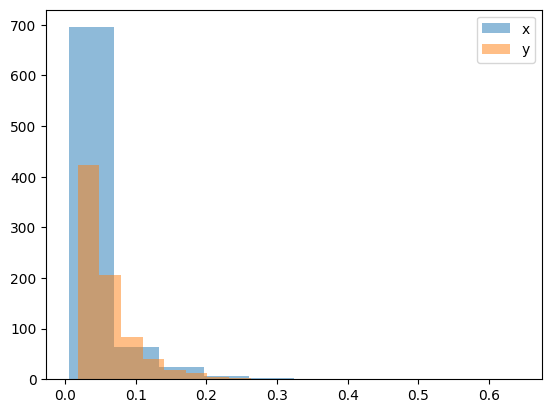

In [52]:
plt.hist(pos_min, alpha=0.5, label='x')
plt.hist(avg_min, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

In [105]:
avg_embeds = []
vox_embeds = []

In [110]:
avg_embeds_euc = []

In [244]:
for i in range(0,50,10):
    print(i)

0
10
20
30
40


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cutoff_avg = []
cutoff_val = []

true_neighbor_fraction = []
cutoff_val.append(cutoff)
ti = 0

cutoff = 300

for pg,lg,ipg in validation_triples:
    ti += 1
    
    lg = lg.to(device)
    ipg = ipg.to(device)
    pg = pg.to(device)

    active_ligand_atoms = torch.unique(radius(ipg.pos, lg.pos, 4)[0])
    active_ligand_pos = lg.pos[active_ligand_atoms]
    active_ligand_x = lg.x[active_ligand_atoms]

    pred_active_voxels = torch.sort(ipg.min_dist, descending=True).indices[:cutoff]
    pred_active_pos = pg.pos[pred_active_voxels]
    pred_active_x = pg.x[pred_active_voxels]
#     pred_active_x = ipg.mean_embed[pred_active_voxels]

    k = 15 
    nearest_neighbors = knn(pred_active_x, active_ligand_x, k, cosine=True)

    nearest_vox_dist = torch.norm(active_ligand_pos[nearest_neighbors[0]] -
                                  pred_active_pos[nearest_neighbors[1]], dim=1)

    true_neighbor_fraction.append(torch.where(torch.min(nearest_vox_dist.reshape(-1, k), dim=1).values < 3**0.5*2)[0].size(0) / active_ligand_atoms.size(0))


print(sum(true_neighbor_fraction) / len(true_neighbor_fraction))

NameError: name 'cutoff' is not defined

In [12]:
ti = 0
cutoff = 300

def to_directed(ei):
    directed_ei = []
    
    for a,b in zip(*ei):
        e = sorted([a.item(), b.item()])
        if e not in directed_ei:
            directed_ei.append(e)
    
    return torch.tensor(directed_ei).T

for pg,lg,ipg in validation_triples:
    ti += 1
    
    lg = lg.to(device)
    ipg = ipg.to(device)
    pg = pg.to(device)

    with torch.no_grad():
        pred_active_voxels = torch.sort(ipg.min_dist, descending=True).indices[:cutoff]
        pred_active_pos = pg.pos[pred_active_voxels]
        pred_active_x = pg.x[pred_active_voxels]

    k = 15 
    nearest_neighbors = knn(pred_active_x, lg.x, k, cosine=True)
    
    neighbor_voxels = nearest_neighbors[1].reshape(-1,k)
    neighbor_voxel_pos = pred_active_pos[neighbor_voxels]
    lg_ei = to_directed(lg.edge_index)
    
    vox_neighbor_ei = []
    
    for e in lg_ei.T:
        source = e[0]
        sink = e[1]
        one_hops = torch.where(torch.cdist(*neighbor_voxel_pos[e]) < 3)
        
        vox_neighbor_sources = k*source+one_hops[0]
        vox_neighbor_sinks = k*sink+one_hops[1]
        
        print(neighbor_voxel_pos.reshape(-1,3)[vox_neighbor_sources.unique()].min(0))
        print(neighbor_voxel_pos.reshape(-1,3)[vox_neighbor_sources.unique()].max(0))
        sys.exit()
        
        
        vox_neighbor_ei.append(torch.vstack((vox_neighbor_sources, 
                                             vox_neighbor_sinks)))
        
    
    vox_neighbor_ei = torch.hstack(vox_neighbor_ei)
        
    break

torch.return_types.min(
values=tensor([284.4708,  -5.4334, -13.1977], device='cuda:0'),
indices=tensor([2, 3, 4], device='cuda:0'))
torch.return_types.max(
values=tensor([289.4708,   4.5666,  -7.1977], device='cuda:0'),
indices=tensor([1, 5, 1], device='cuda:0'))


SystemExit: 

In [121]:
counts = torch.tensor([0,0,0])

for a,b,c in zip(avg_embeds, avg_embeds_euc, vox_embeds):
    counts[torch.argmax(torch.tensor([a,b,c]))] += 1
    
print(counts)

tensor([351, 181, 261])
